# 0.0. IMPORTS

In [20]:
import numpy  as np
import pandas as pd
import inflection

import seaborn as sns

from matplotlib           import pyplot as plt
from IPython.display      import Image
from IPython.core.display import HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = df1.columns
print("Old cols: "+str( cols_old ) )

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )
print("\nSnakecase cols: "+str( cols_new) )

# rename
df1.columns = cols_new

Old cols: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Snakecase cols: ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']


## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format( df1.shape[0] ) )
print('Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance       
max_competition_distance = df1.competition_distance.max()
new_max_competition_distance = max_competition_distance*3
df1.loc[df1.competition_distance.isna(), 'competition_distance'] = new_max_competition_distance

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)


#promo2_since_week         
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)


#promo2_since_year      
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)


#promo_interval              
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [12]:
#promo2 change float64 to int64
df1['promo2_since_week']            = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']            = df1['promo2_since_year'].astype('int64')  

#competition change float64 to int64
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Atributes

In [14]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


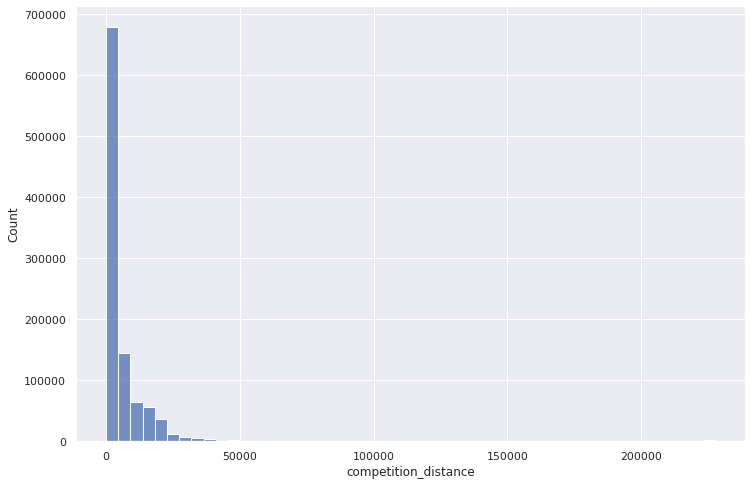

In [15]:
plt.figure(figsize=(12,8))
sns.histplot( df1['competition_distance'], bins=50, kde=False );

### 1.7.2 Categorical Atributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

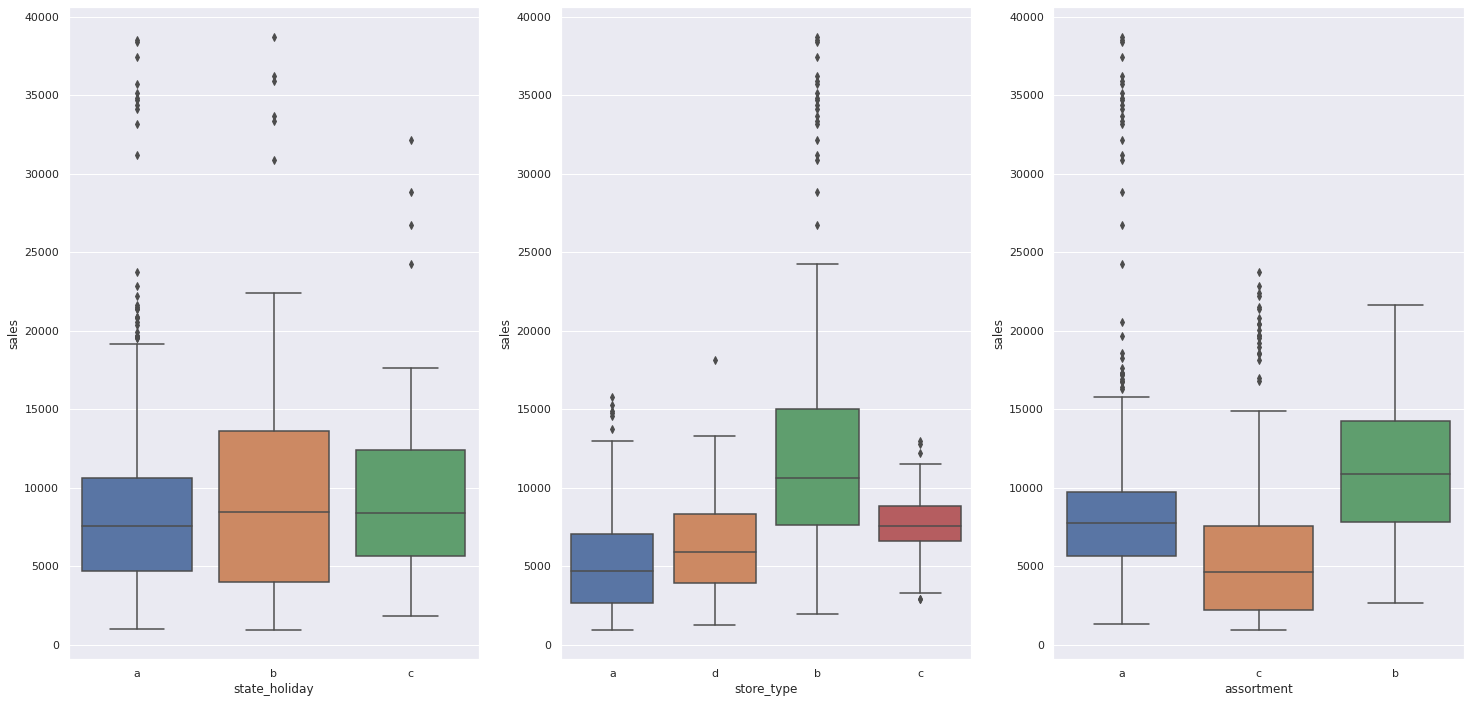

In [17]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. FEATURE ENGINEERING

## 2.1. Hypotheses Mind Map

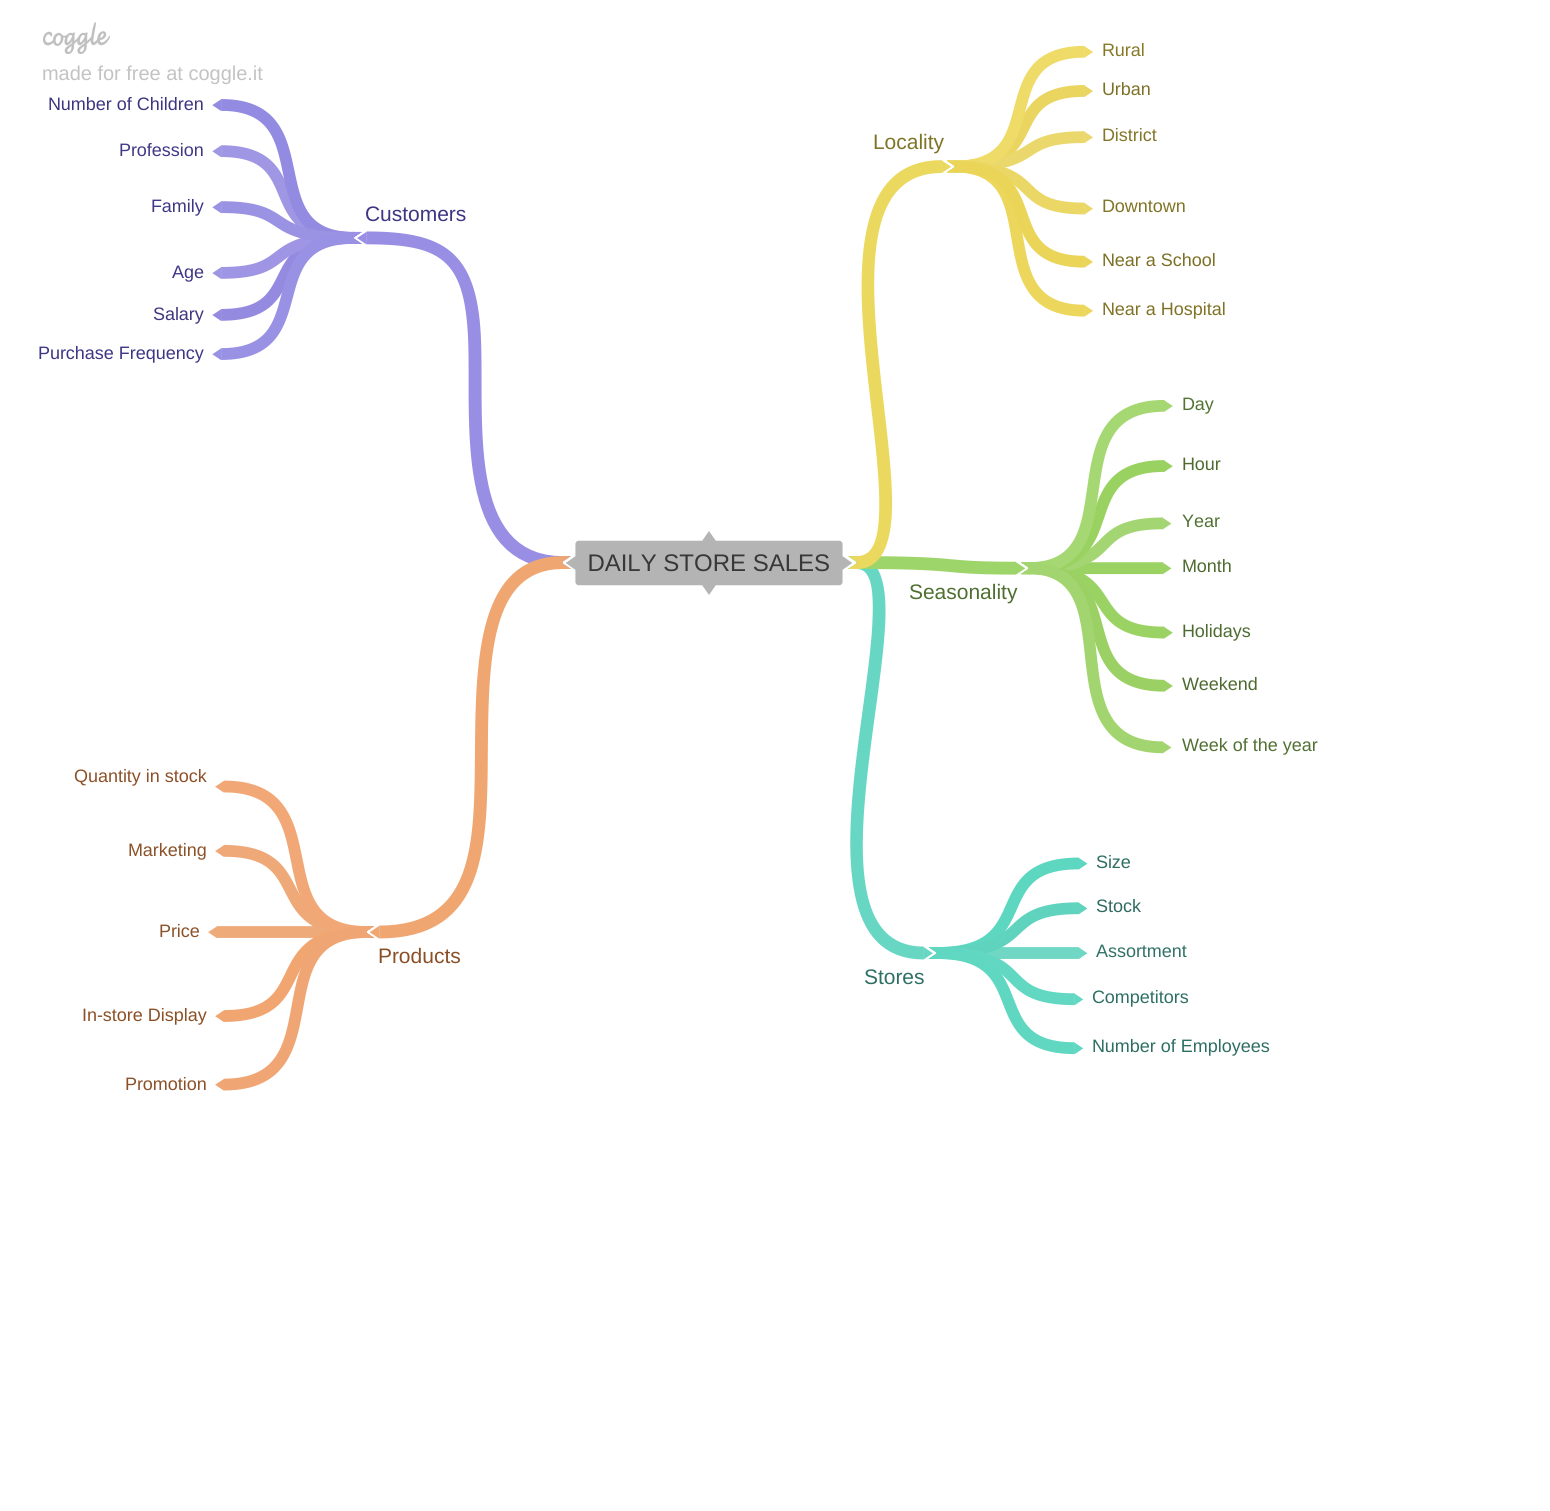

In [23]:
Image( 'img/mind-map-hypotheses.png')

## 2.2. Hypotheses Criation

### 2.2.1 Store Hypotheses



**1.** Stores with a larger number of employees should sell more.

**2.** Stores with more stock should sell more.

**3.** Larger stores should sell more than smaller ones.

**4.** Stores with more assortment should sell more.

**5.** Stores with competitors less than 2KM away shold sell less.


### 2.2.2 Product Hypotheses

**6.** Stores that invest more in marketing should sell more.

**7.** Stores that display more products in their windows should sell more.

**8.** Stores with cheaper products should sell more.

**9.** Stores with longer promotions should sell more.

**10.** Stores with fewer products in stock should sell more.

### 2.2.3 Seasonality Hypotheses

**11.** Stores with more holidays should sell more.

**12.** Stores that display more products in their windows should sell more.

**13.** Stores that open in the first half of the year sell more.

**14.** Stores that open on weekends should sell more.

**15.** Stores sell less in summer.